# Visual Question Answering

The model is a combination of a CNN to encode the image and an LSTM to encode the question. Both outputs are concatenated and run through fully-connected layers. The output is either a binary value (e.g. for yes/no questions) or categorical softmax probabilities. Thus, finding the correct answer is treated as a classification problem.

The data used here comes from the Visual Question Answering Dataset (http://www.visualqa.org/). This dataset offers questions on abstract scenes (only yes/no) as well as questions on COCO images (all kinds of questions).

I tried 3 things:

- yes/no questions on abstract scenes --> accuracy didn't get better than chance for large dataset, for small dataset the network just remembered the image features and didn't care about the question

- yes/no questions on COCO --> lots of samples, memory was too small to compute all image features at once, would need to do this batch-wise

- questions that ask for color on COCO --> got validation accuracy of ~40 %

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import tensorflow as tf
import keras

Using TensorFlow backend.


In [3]:
def load_embeddings(filename, omit_info=True):
    """
    Load embedding vectors from a file in standard word2vec format
    (i.e. one vector per line, with name and vector values separated by spaces).

    Args:
        filename: File that contains the embedding vectors.
        omit_info: Gensim writes the number and dimension of vectors in the first line. If `True`, omit this.

    Returns:
        A dict with vector names as keys and vector values as values.
    """
    vectors = {}
    with open(filename) as f:
        for i, line in enumerate(f):
            line_elements = line.split()
            if omit_info and not (i == 0 and len(
                    line_elements) == 2):  # exclude (num_vectors, num_dimensions) tuples at beginning of gensim vectors files
                vectors[line_elements[0]] = np.array(line_elements[1:], dtype=float)
    return vectors

In [4]:
def init_embedding_layer(layer, embeddings, word_dict, verbose=False):
    """
    Initialize a keras embedding layer with embeddings from a dict or file.
    
    Args:
        layer: An object of type keras.layers.embeddings.Embedding
        embeddings: A dict with words as keys and embedding vectors as values or a text file in word2vec format
        word_dict: A dict with words as keys and indices in the embedding matrix as values (e.g. a keras.preprocessing.text.Tokenizer.word_index object)
        
    Returns:
        None
    """
    try:
        embeddings.keys()  # embeddings is a dict
    except AttributeError:
        embeddings = load_embeddings(embeddings)  # embeddings is a filepath
        
    if verbose:
        print('Found', len(embeddings), 'embeddings')
    
    vocab_size = layer.input_dim
    embedding_dim = layer.output_dim
    if verbose:
        print('Layer contains', vocab_size, 'embeddings of dimension', embedding_dim)
    # TODO: Check if embedding_dim corresponds to the embedding vectors in embeddings.
    weights = np.zeros((vocab_size, embedding_dim))
    
    count = 0
    for word in embeddings:
        if word in word_dict and word_dict[word] < vocab_size:
            count += 1
            weights[word_dict[word]] = embeddings[word]
            
    layer.set_weights([weights])

    if verbose:
        print('Wrote', count, 'embeddings into the layer')

## Load and process data

In [5]:
# Abstract VQA.
questions_filepath = 'data/vqa-abstract/OpenEnded_abstract_v002_train2017_questions.json'
answers_filepath = 'data/vqa-abstract/abstract_v002_train2017_annotations.json'
image_dir = 'data/vqa-abstract/scene_img_abstract_v002_train2017'
image_name_template = 'abstract_v002_train2015_{:012}.png'

In [6]:
# COCO VQA.
questions_filepath = 'data/vqa-coco/v2_OpenEnded_mscoco_train2014_questions.json'
answers_filepath = 'data/vqa-coco/v2_mscoco_train2014_annotations.json'
image_dir = 'data/vqa-coco/train2014'
image_name_template = 'COCO_train2014_{:012}.jpg'

### Questions and answers

In [7]:
import json

In [8]:
with open(questions_filepath) as f:    
    question_json = json.load(f)
question_df = pd.DataFrame(question_json['questions']).set_index('question_id')
print('Read', len(question_df), 'questions')
question_df.head()

Read 443757 questions


image_id                                     question
question_id                                                       
458752000      458752    What is this photo taken looking through?
458752001      458752           What position is this man playing?
458752002      458752             What color is the players shirt?
458752003      458752  Is this man a professional baseball player?
262146000      262146                      What color is the snow?

In [9]:
with open(answers_filepath) as f:
    answers_json = json.load(f)
answer_df = pd.DataFrame(answers_json['annotations']).set_index('question_id')
print('Read', len(answer_df), 'answers')
answer_df.head()

Read 443757 answers


answer_type                                            answers  \
question_id                                                                  
458752000         other  [{u'answer': u'net', u'answer_confidence': u'm...   
458752001         other  [{u'answer': u'pitcher', u'answer_confidence':...   
458752002         other  [{u'answer': u'orange', u'answer_confidence': ...   
458752003        yes/no  [{u'answer': u'yes', u'answer_confidence': u'y...   
262146000         other  [{u'answer': u'white', u'answer_confidence': u...   

             image_id multiple_choice_answer      question_type  
question_id                                                      
458752000      458752                    net       what is this  
458752001      458752                pitcher               what  
458752002      458752                 orange  what color is the  
458752003      458752                    yes            is this  
262146000      262146                  white  what color is the

**Optional: Use only answers which question for color**

In [10]:
answer_df = answer_df[['color' in question for question in answer_df['question_type']]]
print('Found', len(answer_df), 'answers that question for color')
answer_df.head()

Found 41576 answers that question for color


answer_type                                            answers  \
question_id                                                                  
458752002         other  [{u'answer': u'orange', u'answer_confidence': ...   
262146000         other  [{u'answer': u'white', u'answer_confidence': u...   
262146002         other  [{u'answer': u'red', u'answer_confidence': u'y...   
393223001         other  [{u'answer': u'white and purple', u'answer_con...   
393227003         other  [{u'answer': u'backwards', u'answer_confidence...   

             image_id multiple_choice_answer      question_type  
question_id                                                      
458752002      458752                 orange  what color is the  
262146000      262146                  white  what color is the  
262146002      262146                    red  what color is the  
393223001      393223       white and purple  what color is the  
393227003      393227                   blue      what color is

In [11]:
# Remove answers that appear rarely.
min_class_size = 100  # use only answers that appear more often

class_sizes = answer_df['multiple_choice_answer'].value_counts()
answer_df = answer_df[answer_df['multiple_choice_answer'].isin(class_sizes[class_sizes > min_class_size].index)]
classes = answer_df['multiple_choice_answer'].unique()
num_classes = len(answer_df['multiple_choice_answer'].unique())
print('Kept', len(answer_df), 'answers with class size over', min_class_size, '-->', num_classes, 'classes')
answer_df.head()

Kept 39736 answers with class size over 100 --> 21 classes


answer_type                                            answers  \
question_id                                                                  
458752002         other  [{u'answer': u'orange', u'answer_confidence': ...   
262146000         other  [{u'answer': u'white', u'answer_confidence': u...   
262146002         other  [{u'answer': u'red', u'answer_confidence': u'y...   
393227003         other  [{u'answer': u'backwards', u'answer_confidence...   
131084000         other  [{u'answer': u'green', u'answer_confidence': u...   

             image_id multiple_choice_answer      question_type  
question_id                                                      
458752002      458752                 orange  what color is the  
262146000      262146                  white  what color is the  
262146002      262146                    red  what color is the  
393227003      393227                   blue      what color is  
131084000      131084                  green  what color is the

---

**Optional: Use only answers with answer type yes/no**

In [13]:
answer_df = answer_df[answer_df['answer_type'] == 'yes/no']
print('Found', len(answer_df), 'answers with answer type yes/no')
answer_df.head()

Found 22055 answers with answer type yes/no


answer_type                                            answers  \
question_id                                                                  
870              yes/no  [{u'answer': u'no', u'answer_confidence': u'ye...   
900000870        yes/no  [{u'answer': u'no', u'answer_id': 1}, {u'answe...   
149620           yes/no  [{u'answer': u'no', u'answer_confidence': u'ye...   
900149620        yes/no  [{u'answer': u'yes', u'answer_id': 1}, {u'answ...   
82771            yes/no  [{u'answer': u'yes', u'answer_confidence': u'y...   

              image_id multiple_choice_answer question_type  
question_id                                                  
870                 87                    yes    is the boy  
900000870    900000870                     no    is the boy  
149620           14962                     no         is it  
900149620    900149620                    yes         is it  
82771             8277                    yes    is the boy

---

In [12]:
# Merge question and answer dataframes.
df = question_df.merge(answer_df, left_index=True, right_index=True, on='image_id', sort=True)
df['answer'] = df['multiple_choice_answer']
# Remove some columns to make the dataframe more compact.
del df['answer_type'], df['answers'], df['question_type'], df['multiple_choice_answer']
print('Merged answers and question into', len(df), 'pairs, corresponding to', len(df['image_id'].unique()), 'unique images')
df.head()

Merged answers and question into 39736 pairs, corresponding to 29451 unique images


image_id                                           question  \
question_id                                                                
30004              30                            What color is the vase?   
36001              36                        What color is the umbrella?   
49001              49          What color horse is closer to the camera?   
61003              61  What color is the person on the elephant in th...   
89001              89                       What color is the microwave?   

            answer  
question_id         
30004        white  
36001         pink  
49001        black  
61003          red  
89001        black

In [13]:
# Analyze number of individual words. Set parameter `vocab_size` below to cover the majority of words.
from keras.preprocessing import text, sequence
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df['question'].apply(str))  # convert to non-unicode
len(tokenizer.word_index)

2512

In [14]:
vocab_size = 2512

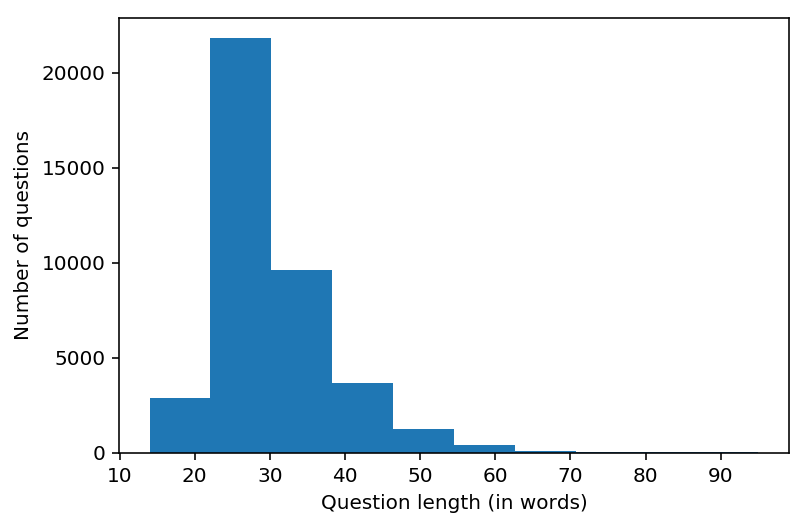

In [15]:
# Analyze distribution of question lengths. Set parameter `text_length` below to fit most questions.
plt.hist(map(len, df['question']))
plt.xlabel('Question length (in words)')
plt.ylabel('Number of questions')

In [16]:
text_length = 80

In [17]:
# Convert question strings to fixed-length integer sequences.
from keras.preprocessing import text, sequence
tokenizer = keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['question'].apply(str))  # convert to non-unicode
sequences = tokenizer.texts_to_sequences(df['question'].apply(str))
padded_sequences = keras.preprocessing.sequence.pad_sequences(sequences, text_length)
X_questions = padded_sequences
X_questions.shape

(39736, 80)

In [18]:
# Gather all embedding labels and prepare a function to write them to file.
# This function is called during training to store the embedding labels in the log dir
# (required for the Tensorboard Embedding Projector).
embedding_labels = sorted(tokenizer.word_index.keys(), key=tokenizer.word_index.get)[:vocab_size-1]
embedding_labels = ['<UNK>'] + embedding_labels  # zero is masked
print('Stored', len(embedding_labels), 'embedding labels to write to file')

import os

def store_embedding_labels(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
    with open(os.path.join(directory, 'embedding_labels.txt'), 'w') as f:
        f.write('\n'.join(embedding_labels))

Stored 2512 embedding labels to write to file


**Option 1: Convert yes/no answers to binary values**

In [21]:
y = df['answer'].apply(lambda answer: 0 if answer == 'no' else 1).values
y.shape

(22055,)

**Option 2: Convert categorical answers to one-hot vectors**

In [19]:
index_to_answer = dict(enumerate(answer_df['multiple_choice_answer'].unique()))
answer_to_index = {value: key for key, value in index_to_answer.iteritems()}

y = df['answer'].apply(lambda answer: answer_to_index[answer]).values
y = keras.utils.to_categorical(y)
y.shape

(39736, 21)

### Images

In [54]:
import keras.preprocessing.image
import os
from tqdm import tqdm_notebook

In [55]:
# TODO: Try vqa-abstract with 224, 224.
images = np.zeros((len(df), 224, 224, 3), dtype='uint8')

for i, image_id in enumerate(tqdm_notebook(df['image_id'])):
    image_filepath = os.path.join(image_dir, image_name_template.format(image_id))
    image = keras.preprocessing.image.load_img(image_filepath, target_size=(224, 224))
    images[i] = keras.preprocessing.image.img_to_array(image)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


**Save/load images as array**

In [56]:
np.save('data/vqa-coco/images-color.npy', images)

In [20]:
images = np.load('data/vqa-coco/images-color.npy')

### Show some samples

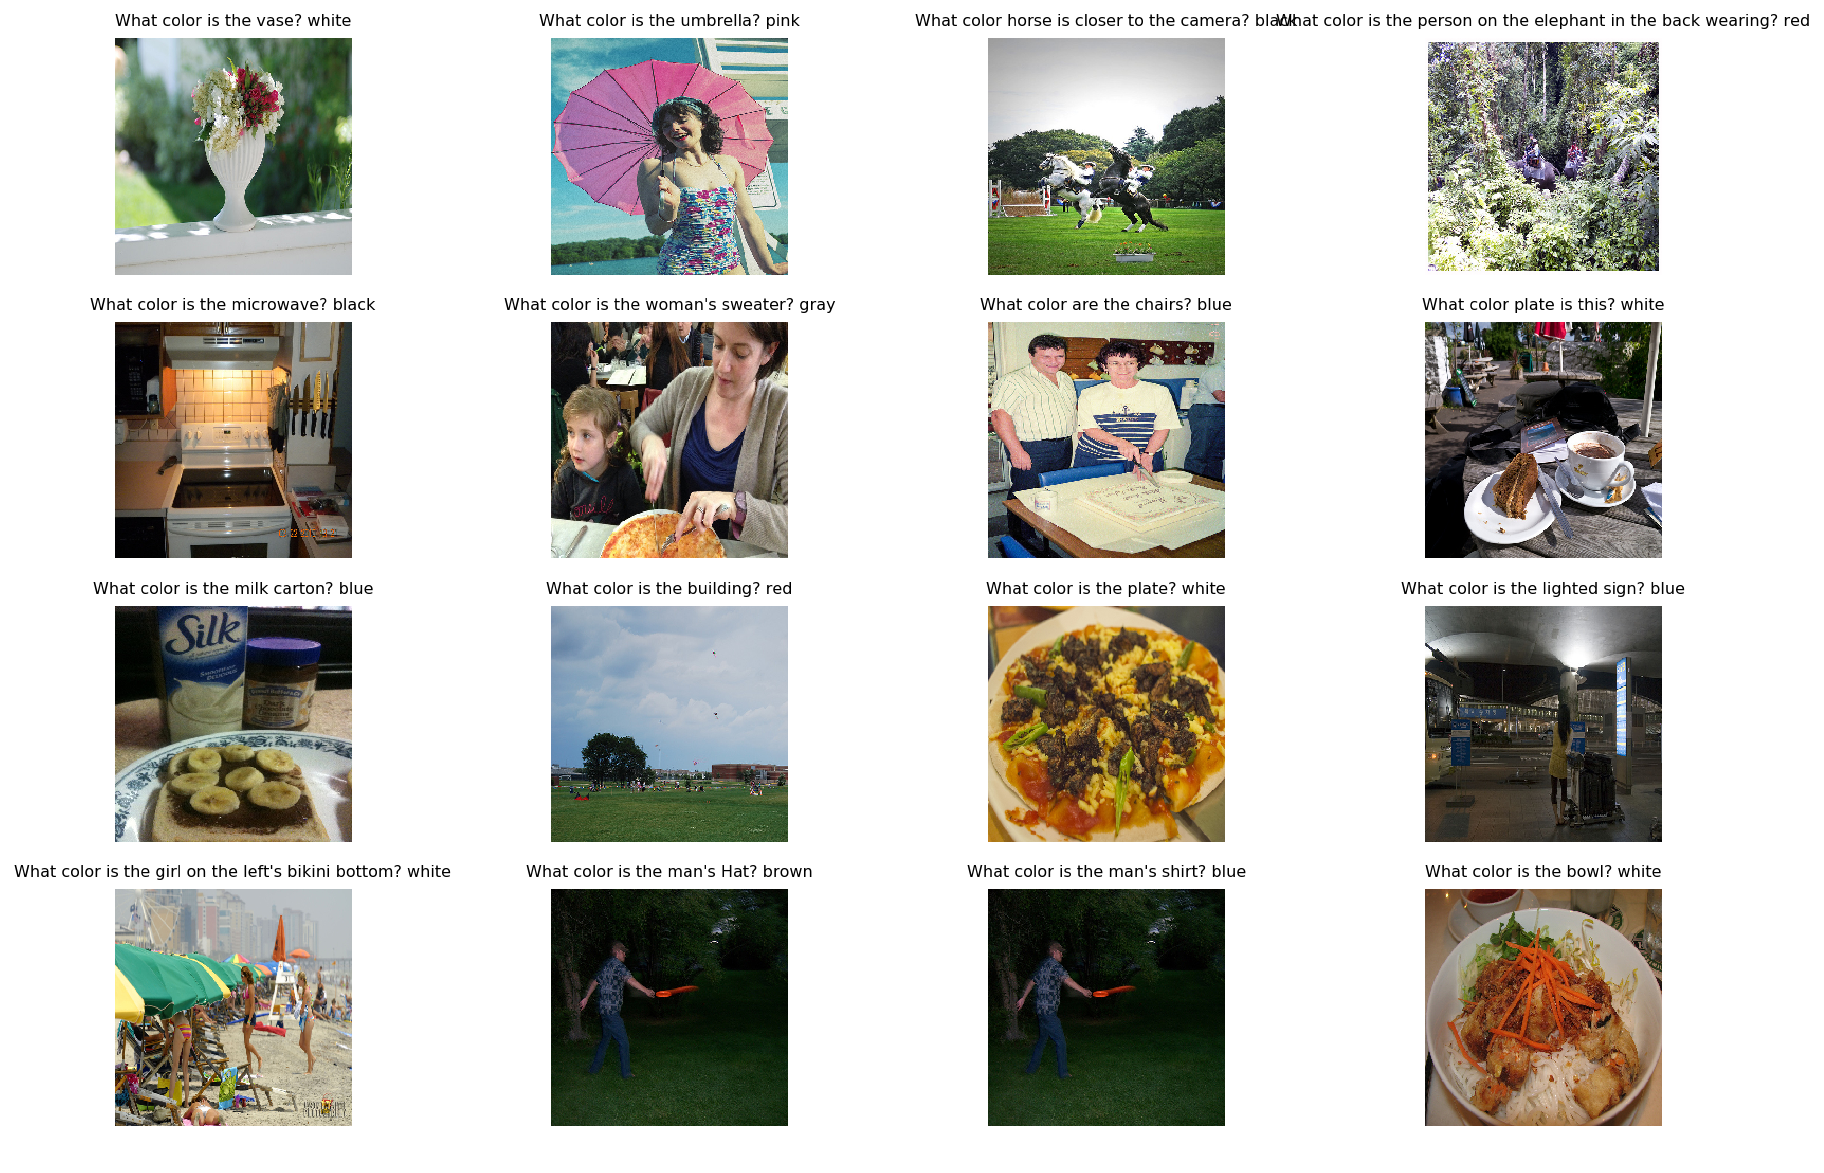

In [21]:
fig, axes = plt.subplots(4, 4, figsize=(15, 10))

for i, ax in enumerate(axes.flatten()):
    plt.sca(ax)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(df['question'].iloc[i] + ' ' + df['answer'].iloc[i], fontsize=8)

## Compute image features via CNN

In [59]:
cnn_model = keras.applications.vgg16.VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False, pooling='avg')

In [ ]:
X_images = keras.applications.vgg16.preprocess_input(images.astype('float32'))
X_images.shape

In [60]:
precomputed_image_features = cnn_model.predict(X_images, verbose=1)
precomputed_image_features.shape

27488/39736 [===================>..........] - ETA: 6011

limit_output extension: Maximum message size of 100000 exceeded with 100090 characters

**Save/load image features**

In [61]:
np.save('data/vqa-coco/precomputed_image_features-color.npy', precomputed_image_features)

In [22]:
precomputed_image_features = np.load('data/vqa-coco/precomputed_image_features-color.npy')

## Train VQA model

### Create custom model

In [25]:
image_features = keras.layers.Input(shape=(512, ))
encoded_image = keras.layers.Dense(256)(image_features)

In [26]:
question = keras.layers.Input(shape=(text_length, ), dtype='int32')
embedding_layer = keras.layers.Embedding(vocab_size, 100, mask_zero=True, name='embeddings', input_length=text_length)
embeddings = embedding_layer(question)  # Original example: 256 embedding size
encoded_question = keras.layers.LSTM(128)(embeddings)

**Optional: Initialize embedding layer with pre-trained GLOVE embeddings**

The embeddings can be found at: https://nlp.stanford.edu/projects/glove/

In [27]:
init_embedding_layer(embedding_layer, 'data/glove.6B/glove.6B.100d.txt', tokenizer.word_index, verbose=True)
embedding_layer.trainable = False

Found 400000 embeddings
Layer contains 2774 embeddings of dimension 100
Wrote 2722 embeddings into the layer


---

In [28]:
x = keras.layers.concatenate([encoded_image, encoded_question])
x = keras.layers.Dense(128, activation='relu')(x)

**Option 1: Binary output (e.g. yes/no questions)**

In [29]:
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

**Option 2: Categorical output (with softmax)**

In [37]:
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
loss = 'categorical_crossentropy'
metrics = ['accuracy']

---

In [30]:
model = keras.models.Model([image_features, question], outputs)

In [31]:
model.compile(optimizer='adam', loss=loss, metrics=metrics)

### Create model from https://github.com/anantzoid/VQA-Keras-Visual-Question-Answering/blob/master/models.py

This was only for experimentation and is not properly tested!

In [83]:
def get_embedding_weights(vocab_size, embedding_dim, embeddings, word_dict, verbose=False):
    """
    Initialize a keras embedding layer with embeddings from a dict or file.
    
    Args:
        layer: An object of type keras.layers.embeddings.Embedding
        embeddings: A dict with words as keys and embedding vectors as values or a text file in word2vec format
        word_dict: A dict with words as keys and indices in the embedding matrix as values (e.g. a keras.preprocessing.text.Tokenizer.word_index object)
        
    Returns:
        None
    """
    try:
        embeddings.keys()  # embeddings is a dict
    except AttributeError:
        embeddings = load_embeddings(embeddings)  # embeddings is a filepath
        
    if verbose:
        print('Found', len(embeddings), 'embeddings')
    
    #vocab_size = layer.input_dim
    #embedding_dim = layer.output_dim
    if verbose:
        print('Layer contains', vocab_size, 'embeddings of dimension', embedding_dim)
    # TODO: Check if embedding_dim corresponds to the embedding vectors in embeddings.
    weights = np.zeros((vocab_size, embedding_dim))
    
    count = 0
    for word in embeddings:
        if word in word_dict and word_dict[word] < vocab_size:
            count += 1
            weights[word_dict[word]] = embeddings[word]
            
    return weights

In [85]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, Flatten, Embedding, Merge
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D

def Word2VecModel(num_words, embedding_dim, seq_length, dropout_rate):
    print("Creating text model...")
    model = Sequential()
    
    embedding_matrix = get_embedding_weights(num_words, embedding_dim, 'data/glove.6B/glove.6B.300d.txt', tokenizer.word_index, verbose=True)

    model.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=seq_length, trainable=False))
    model.add(LSTM(output_dim=512, return_sequences=True, input_shape=(seq_length, embedding_dim)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(output_dim=512, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(512, activation='tanh'))
    return model

def img_model(dropout_rate):
    print("Creating image model...")
    model = Sequential()
    model.add(Dense(512, input_dim=512, activation='tanh'))
    return model

def vqa_model(num_words, embedding_dim, seq_length, dropout_rate):
    vgg_model = img_model(dropout_rate)
    lstm_model = Word2VecModel(num_words, embedding_dim, seq_length, dropout_rate)
    print("Merging final model...")
    fc_model = Sequential()
    fc_model.add(Merge([vgg_model, lstm_model], mode='mul'))
    fc_model.add(Dropout(dropout_rate))
    fc_model.add(Dense(1000, activation='tanh'))
    fc_model.add(Dropout(dropout_rate))
    fc_model.add(Dense(1, activation='sigmoid'))
    fc_model.compile(optimizer='rmsprop', loss='binary_crossentropy',
        metrics=['binary_accuracy'])
    return fc_model

model = vqa_model(vocab_size, 300, text_length, 0.2)

Creating image model...
Creating text model...
Found 400000 embeddings
Layer contains 1000 embeddings of dimension 300


/Users/d068730/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=512, return_sequences=True, input_shape=(80, 300))`
/Users/d068730/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=512, return_sequences=False)`


Merging final model...


/Users/d068730/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:30: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


### Train

In [ ]:
n = -1  # set to -1 to use complete dataset
run_name = '38_abstract-binary-adam'
run_dir = 'logs/' + run_name

# Store embeddings labels in logs dir so that they show up in the Tensorboard Embedding Projector.
store_embedding_labels(run_dir)

model.fit([precomputed_image_features[:n], X_questions[:n]], y[:n], epochs=10, batch_size=64, validation_split=0.1, 
          callbacks=[keras.callbacks.TensorBoard(log_dir=run_dir, 
                                                 histogram_freq=0,  # buggy
                                                 embeddings_freq=1, embeddings_layer_names=['embeddings'], embeddings_metadata={'embeddings': 'embedding_labels.txt'})])

**Findings for color questions on vqa-coco:**

- adam yields slightly better results than rmsprop (around 5 % training accuracy; both with default parameters)
- best run was number 37: validation accuracy saturates after ~10 epochs at 41 %, training accuracy keeps increasing a bit beyond that without regularization
- analyzed via the interactive demo below: sometimes the answer seems to be based only on the image (e.g. if there are very salient objects), sometimes the answer seems to be based only on the question (e.g. what color is the snow?), but sometimes the model correctly combines image and question

**Save/load trained model**

In [58]:
#model.save('data/vqa-coco/model-37.h5')

In [22]:
model = keras.models.load_model('data/vqa-coco/model-37.h5')

## Evaluate

### Show some samples

Got 13 out of 20 correct


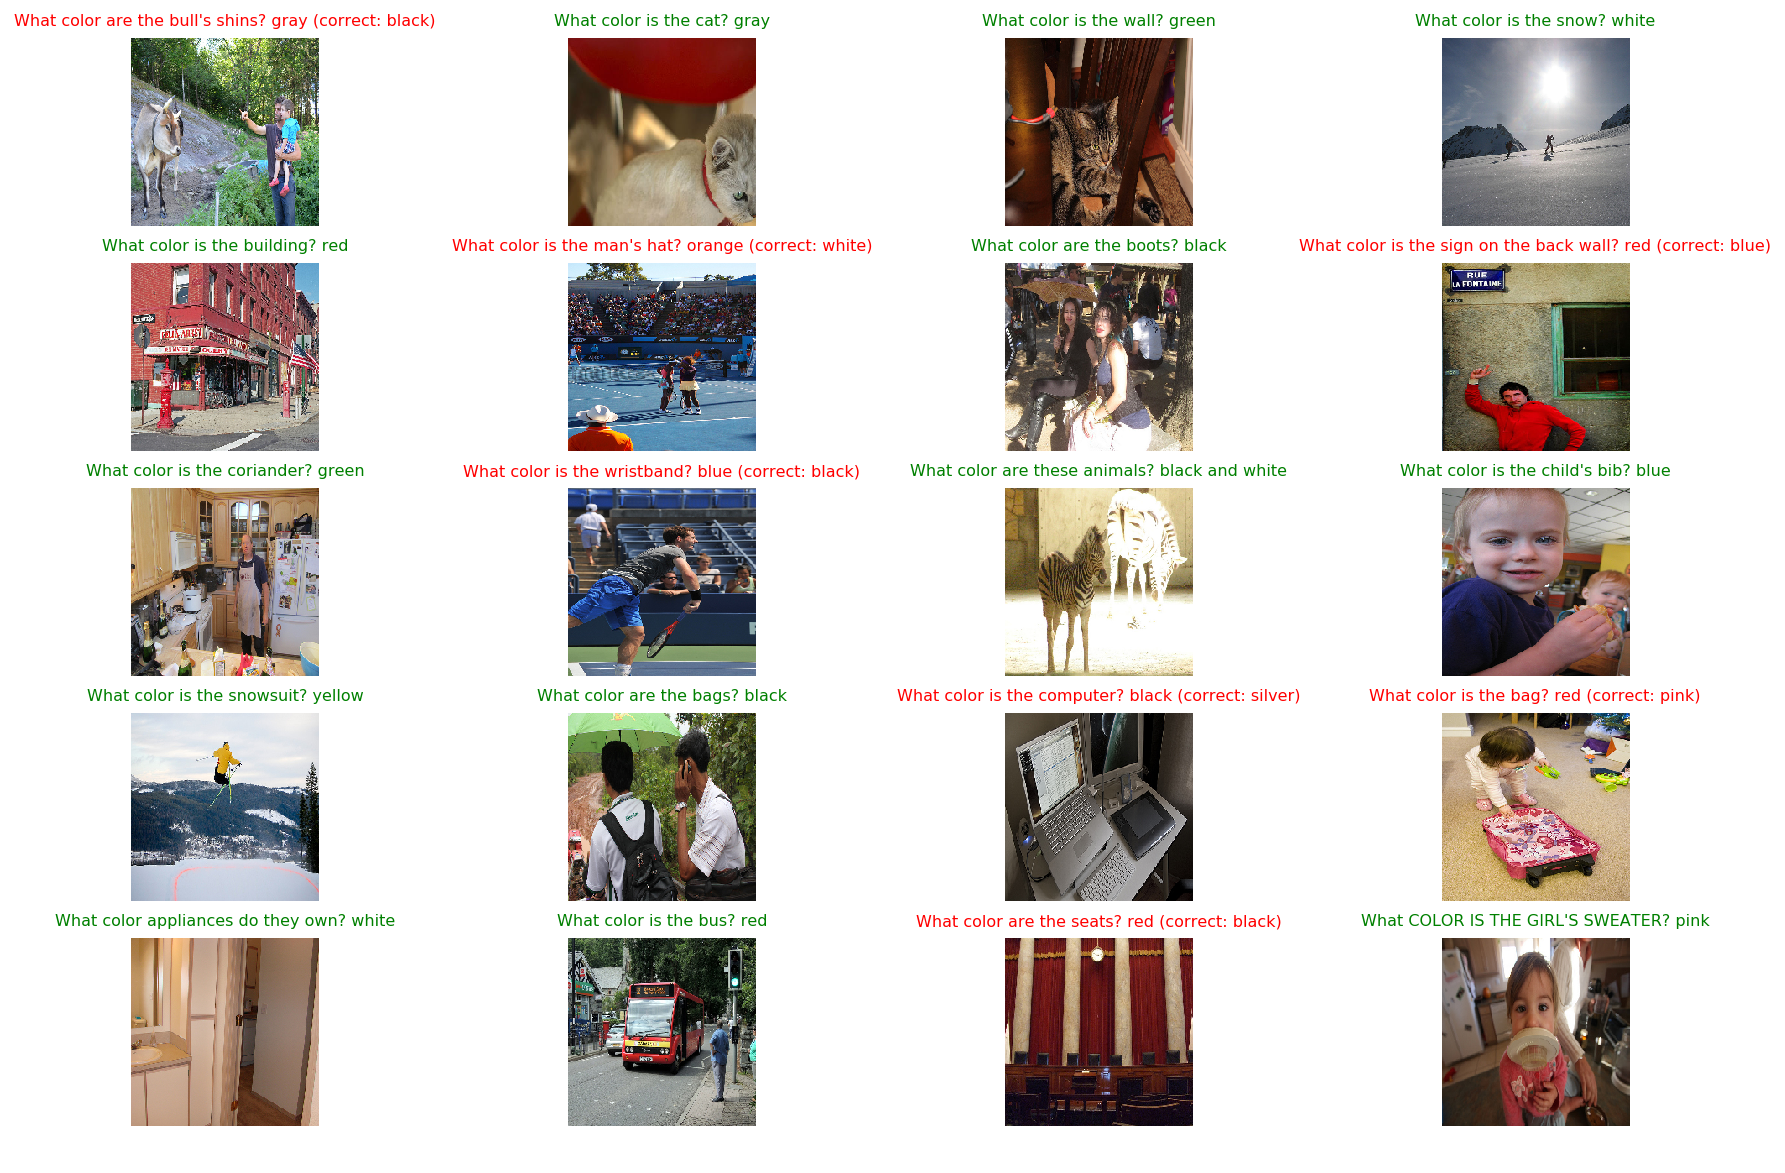

In [26]:
fig, axes = plt.subplots(5, 4, figsize=(15, 10))
ind = np.random.choice(len(df), size=axes.size)
pred_y = model.predict([precomputed_image_features[ind], X_questions[ind]])
pred_answers = np.array([index_to_answer[x] for x in pred_y.argmax(axis=-1)])
#pred_answers = ['no' if x < 0.5 else 'yes' for x in pred_y.flatten()]

print('Got {} out of {} correct'.format(np.sum(pred_answers == df['answer'].iloc[ind]), len(pred_answers)))

for i, ax in enumerate(axes.flatten()):
    plt.sca(ax)
    plt.imshow(images[ind[i]])
    plt.axis('off')
    
    question = df['question'].iloc[ind[i]]
    pred_answer = pred_answers[i]
    correct_answer = df['answer'].iloc[ind[i]]
    
    if pred_answer == correct_answer:
        plt.title('{} {}'.format(question, pred_answer), fontsize=8, color='g')
    else:
        plt.title('{} {} (correct: {})'.format(question, pred_answer, correct_answer), fontsize=8, color='r')

### Interactive demo

In [34]:
from ipywidgets import interact_manual, interact

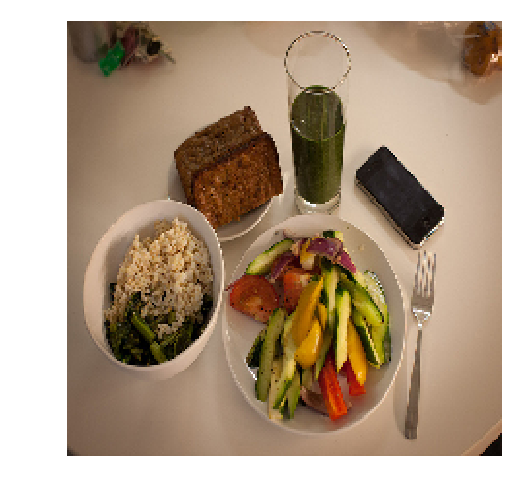

In [36]:
image_global = 0

@interact(image=(0, len(images)-1))
def plot_image(image=0):
    global image_global
    image_global = image
    plt.imshow(images[image])
    plt.axis('off')

In [43]:
@interact_manual(question=df['question'].iloc[image_global])
def get_answer(question):
    sequences = tokenizer.texts_to_sequences([str(question)])
    padded_sequences = keras.preprocessing.sequence.pad_sequences(sequences, text_length)
    y_pred = model.predict([precomputed_image_features[image_global:image_global+1], padded_sequences])
    #pred_answer = 'no' if y_pred[0][0] < 0.5 else 'yes'
    pred_answer = index_to_answer[y_pred[0].argmax()]
    score = y_pred[0].max()
    
    if question == df['question'].iloc[image_global]:
        correct_answer = df['answer'].iloc[image_global]
        print('{} (confidence: {}, correct: {})'.format(pred_answer, score, correct_answer))
    else:
        print('{} (confidence: {})'.format(pred_answer, score))

white (confidence: 0.443177819252)
